In [ ]:
import pandas as pd
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
#Пути
dataset_paths = [
    '/content/drive/MyDrive/DataSet/testpola.parquet',
    '/content/drive/MyDrive/DataSet/tweet_emotions.csv',
    '/content/drive/MyDrive/DataSet/emotion_sentimen_dataset.csv',
    '/content/drive/MyDrive/DataSet/text.csv',
]
data_parquet = pd.read_parquet(dataset_paths[0])
data_parquet = data_parquet.reset_index(drop=True)
datasets_csv = [pd.read_csv(path) for path in dataset_paths[1:]]

datasets_csv[0] = datasets_csv[0].rename(columns={'content': 'text', 'sentiment': 'label'})
datasets_csv[0]['label'] = datasets_csv[0]['label'].map({
    'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5
})
datasets_csv[1] = datasets_csv[1].rename(columns={'text': 'text', 'Emotion': 'label'})
datasets_csv[1]['label'] = datasets_csv[1]['label'].map({
    'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5, 'neutral': 6, 'hate': 7, 'enthusiasm': 8
})
datasets_csv[2] = datasets_csv[2].rename(columns={'Unnamed: 0': 'index'}).drop(columns=['index'])
datasets_csv[2] = datasets_csv[2].reset_index(drop=True)
data_parquet = data_parquet.rename(columns={'text': 'text', 'label': 'label'})

data = pd.concat([data_parquet] + datasets_csv, ignore_index=True)

data = data[data['label'].isin(emotion_map.keys())]
data['Unnamed: 0'] = data.index
if 'tweet_id' in data.columns:
    data = data.drop(columns=['tweet_id'])
data['emotion'] = data['label'].map(emotion_map)
data_filtered = data.dropna(subset=['text', 'label'])
data_filtered['label'] = data_filtered['label'].astype(int)
data_filtered[['Unnamed: 0', 'text', 'label']].to_csv('/content/drive/MyDrive/DataSet/filtered_data.csv', index=False)
print("\nДатасет успешно сохранен в filtered_data.csv")


Датасет успешно сохранен в filtered_data.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
import warnings
warnings.filterwarnings ('ignore')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/DataSet/translated_file.csv"
# Загрузка данных
df = pd.read_csv(DATASET_PATH)
df = df.drop(columns=['Unnamed: 0'])
df = df.drop_duplicates()

In [ ]:
def null_count(df):
    return pd.DataFrame({
        'features': df.columns,
        'dtypes': df.dtypes.values,
        'NaN count': df.isnull().sum().values,
        'NaN percentage': df.isnull().sum().values / df.shape[0]
    }).style.background_gradient(cmap='turbo', low=0.1, high=0.01)
null_count(df)

,features,dtypes,NaN count,NaN percentage
0,text,object,0,0.000000
1,label,int64,0,0.000000
2,translated_column,object,0,0.000000


In [ ]:
# функция очистки текста
def clean_text(text, stemmer, stop_words):
    if not isinstance(text, str):  # защита от NaN
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tokens = word_tokenize(text)
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return ' '.join(cleaned_tokens)

In [ ]:
df['text'] = df['translated_column']
df = df.drop(columns=['translated_column'])
df = df.dropna(subset=['text'])

In [ ]:
df['text'].head()

,text
0,"я чувствую себя ужасно из-за этого, потому что..."
1,в одиночестве я чувствую себя ужасно
2,"я, вероятно, уже упоминал об этом раньше, но я..."
3,я чувствовал себя немного низко несколько дней...
4,"я уверен, что я гораздо более чувствителен к ч..."


In [ ]:
#обработка текста
stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words('russian'))
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x, stemmer, stop_words))
print(df[['text', 'cleaned_text']])
emotion_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
df['Emotion'] = df['label'].map(emotion_mapping)

                                                     text  \
0       я чувствую себя ужасно из-за этого, потому что...   
1                    в одиночестве я чувствую себя ужасно   
2       я, вероятно, уже упоминал об этом раньше, но я...   
3       я чувствовал себя немного низко несколько дней...   
4       я уверен, что я гораздо более чувствителен к ч...   
...                                                   ...   
466445  я провел один, не чувствуя себя нелюбимым и бр...   
466446  я люблю этого ребенка и чувствую себя привилег...   
466450  я чувствовала себя бесполезной и безнадежной в...   
466451  я чувствую себя одним из популярных детей на д...   
466453  я действительно чувствую себя умным в классе, ...   

                                             cleaned_text  
0       чувств ужасн изз эт работ получ состоян преусп...  
1                                 одиночеств чувств ужасн  
2       вероятн упомина раньш действительн горж соб са...  
3                  чувствов

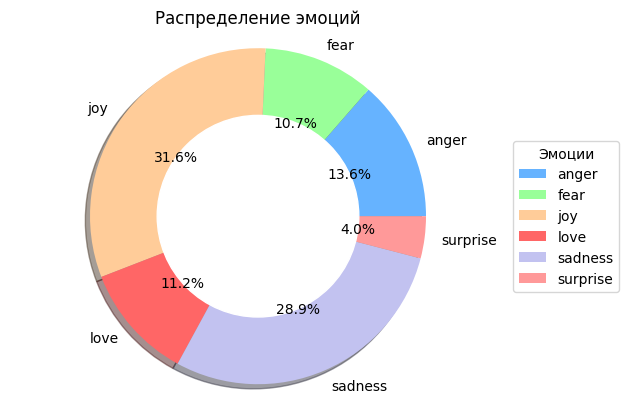

In [ ]:
# Визуализация распределения эмоций
def plot_emotion_distribution(df):
    emotion_counts = df.groupby("Emotion").size()
    colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff6666', '#c2c2f0', '#ff9999']  # Цвета для категорий
    fig, ax = plt.subplots()
    ax.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', colors=colors, explode=[0]*len(emotion_counts), shadow=True)
    ax.add_artist(plt.Circle((0, 0), 0.6, color='white'))
    ax.legend(emotion_counts.index, title="Эмоции", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    ax.axis('equal')
    plt.title('Распределение эмоций')
    plt.show()
plot_emotion_distribution(df)


In [ ]:
# Подготовка данных для модели
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=500, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=500, padding='post')

In [ ]:
word_index = tokenizer.word_index
import json

# Сохраняем word_index в файл
with open('word_index.json', 'w') as f:
    json.dump(word_index, f)

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('russian'))
with open("stopwords.txt", "w") as f:
    for word in stop_words:
        f.write(word + "\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#модель CNN
def build_cnn_model(input_dim=50000, output_dim=16, input_length=500, num_classes=6):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Обучение
def train_model(model, X_train, y_train, X_val, y_val, epochs=15, patience=3):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train.astype(int), y_train.astype(int), epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])
    return history

history_cnn = train_model(cnn_model, X_train_padded, y_train, X_test_padded, y_test)
def evaluate_model(model, X_test, y_test):
    evaluation_result = model.evaluate(X_test, y_test)
    print("Test Loss:", evaluation_result[0])
    print("Test Accuracy:", evaluation_result[1])

evaluate_model(cnn_model, X_test_padded, y_test)

Epoch 1/15
11135/11135 ━━━━━━━━━━━━━━━━━━━━ 553s 49ms/step - accuracy: 0.7304 - loss: 0.7082 - val_accuracy: 0.8051 - val_loss: 0.4608
Epoch 2/15
11135/11135 ━━━━━━━━━━━━━━━━━━━━ 564s 50ms/step - accuracy: 0.8230 - loss: 0.4222 - val_accuracy: 0.8090 - val_loss: 0.4535
Epoch 3/15
11135/11135 ━━━━━━━━━━━━━━━━━━━━ 547s 48ms/step - accuracy: 0.8365 - loss: 0.3786 - val_accuracy: 0.8073 - val_loss: 0.4534
Epoch 4/15
11135/11135 ━━━━━━━━━━━━━━━━━━━━ 574s 49ms/step - accuracy: 0.8459 - loss: 0.3496 - val_accuracy: 0.8034 - val_loss: 0.4657
Epoch 5/15
11135/11135 ━━━━━━━━━━━━━━━━━━━━ 557s 49ms/step - accuracy: 0.8532 - loss: 0.3270 - val_accuracy: 0.7990 - val_loss: 0.4866
Epoch 6/15
11135/11135 ━━━━━━━━━━━━━━━━━━━━ 554s 50ms/step - accuracy: 0.8584 - loss: 0.3108 - val_accuracy: 0.7986 - val_loss: 0.5053
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.8068 - loss: 0.4519
Test Loss: 0.4534192979335785
Test Accuracy: 0.8073416948318481


In [ ]:
import tensorflow as tf
cnn_model.save('cnn_model_ru.keras')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("cnn_model_ru.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("cnn_model_ru.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpq1h6vmqp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 500), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140464971633616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140464971639760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140464971634384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140464971634000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140464971644752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140464971629584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140464971635344: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

nltk.download('punkt')
nltk.download('stopwords')


stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    print("Исходный текст:", text)
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)

    print("После очистки от URL и спецсимволов:", text)
    tokens = word_tokenize(text)
    print("Токенизированный текст:", tokens)

    cleaned_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    print("После стемминга и удаления стоп-слов:", cleaned_tokens)
    return ' '.join(cleaned_tokens)
def load_tflite_model(model_path):
    try:
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()
        print(f"Модель загружена из {model_path}")
        return interpreter
    except Exception as e:
        print(f"Ошибка при загрузке модели: {e}")
        return None

def predict_emotion(interpreter, tokenizer, input_text, max_len=500):
    print(f"\nПрогнозируем эмоцию для текста: '{input_text}'")
    cleaned_text = clean_text(input_text)
    text_sequence = tokenizer.texts_to_sequences([cleaned_text])
    print(f"Текст после преобразования в последовательность индексов: {text_sequence}")

    text_padded = pad_sequences(text_sequence, maxlen=max_len, padding='post')
    print(f"Текст после паддинга: {text_padded}")

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], text_padded.astype(np.float32))
    interpreter.invoke()

    prediction = interpreter.get_tensor(output_details[0]['index'])
    print(f"Предсказание модели (логиты): {prediction}")

    predicted_label = np.argmax(prediction, axis=1)[0]
    print(f"Предсказанная метка (индекс): {predicted_label}")

    emotion_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
    predicted_emotion = emotion_map[predicted_label]

    print(f"Предсказанная эмоция: {predicted_emotion}")
    return predicted_emotion

def emotion_recognition_loop(model_path, tokenizer):
    print("Введите текст, чтобы распознать эмоцию (для выхода напишите 'exit'): ")
    interpreter = load_tflite_model(model_path)
    if not interpreter:
        return

    while True:
        input_text = input("Введите текст: ")
        if input_text.lower() == 'exit':
            print("Выход из программы.")
            break
        predicted_emotion = predict_emotion(interpreter, tokenizer, input_text)
        print(f"Предсказанная эмоция: {predicted_emotion}")

model_path = '/content/cnn_model_no_flex.tflite'  # Укажите путь к модели
emotion_recognition_loop(model_path, tokenizer)





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Введите текст, чтобы распознать эмоцию (для выхода напишите 'exit'): 
Модель загружена из /content/cnn_model_no_flex.tflite
Введите текст: i am so happy

Прогнозируем эмоцию для текста: 'i am so happy'
Исходный текст: i am so happy
После очистки от URL и спецсимволов: i am so happy
Токенизированный текст: ['i', 'am', 'so', 'happy']
После стемминга и удаления стоп-слов: ['happi']
Текст после преобразования в последовательность индексов: [[52]]
Текст после паддинга: [[52  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0

KeyboardInterrupt: Interrupted by user

In [ ]:
import tensorflow as tf
import numpy as np

model_path = '/content/cnn_model.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']
print(f"Expected input shape: {input_shape}")
print(f"Input dtype: {input_dtype}")

input_data = np.random.random([1, 500]).astype(np.float32)
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_data)
try:
    interpreter.invoke()
except Exception as e:
    print("Error during model inference:", e)

output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output data:", output_data)
predicted_class = np.argmax(output_data, axis=1)
print(f"Predicted class: {predicted_class}")


Input details: [{'name': 'serving_default_inputs:0', 'index': 0, 'shape': array([  1, 500], dtype=int32), 'shape_signature': array([ -1, 500], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 55, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([-1,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Expected input shape: [  1 500]
Input dtype: <class 'numpy.float32'>
Error during model inference: tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 15 (READ_VARIABLE) failed to invoke.
Output data: [[-0.0308024  -